# Projet de Machine Learning  UMONS 2024-2025

### Thème : Prédiction du score de Macron aux 2nd Tour des éléctions 2022

----

# Configuration et Installation des Dépendances

----

## a. importation des bibliothèques et dépendance

In [12]:
# @title manipulation des vecteurs
import pandas as pd
import numpy as np

# @title création des graphiques
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick
from tqdm import tqdm

# @title prétraitement des données en masse
from sklearn.preprocessing import OneHotEncoder, RobustScaler , FunctionTransformer
from sklearn.compose import ColumnTransformer , make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# @title selection des features
from collections import defaultdict
from sklearn.feature_selection import SelectFromModel
from functools import lru_cache
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV

# @title sélection du meilleur modèle
from sklearn.model_selection import train_test_split, KFold, cross_val_score , RepeatedKFold
from typing import Dict, Any, Tuple , List
from sklearn.base import clone
from sklearn.model_selection import GridSearchCV

# @title fonction de score et evaluation
from scipy import stats
from sklearn.metrics import mean_squared_error, r2_score ,mean_absolute_error


# @title initialisation des modèles
from sklearn.linear_model import ElasticNet , Lasso
from xgboost import XGBRegressor

# @title options sytèmes
import os
import sys
import joblib
import json
import warnings
import glob
import re
from IPython.display import Markdown, display
from os.path import join


## b. Configuration


In [13]:
#Pour ignorer les warnings
warnings.filterwarnings('ignore')

# configuration des graphiques
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_palette('Set2')

# Pour une meilleure lisibilité dans le notebook
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', '{:.3f}'.format)

print("chargement des bibliothèques terminé")

chargement des bibliothèques terminé


## c. Constantes

In [14]:
# @title Paramètres globaux
MISSINGTHRESHOLD = 60 # @param {"type":"integer"}
RANDOM_STATE = 42 # @param {"type":"integer"}
IDs= [] # @param {type:"raw"}

## d. Fonctions utilitaires

In [ ]:
# @title Utilitaires

def sep(lg=90):
    """Affiche une ligne de séparation"""
    print("\n" + "-"*lg + "\n")

def sub(l1,l2):
  """Retourne la liste des éléments de l1 qui ne sont pas dans l2"""
  return [x for x in l1 if x not in l2]

def get_columns_above_missing_threshold(df, threshold:int=MISSINGTHRESHOLD):
    """
    Identifie les colonnes ayant un pourcentage de valeurs manquantes supérieur au seuil spécifié.

    Args:
        df (pandas.DataFrame): Le DataFrame à analyser
        threshold (float): Le seuil en pourcentage (entre 0 et 100) au-delà duquel une colonne est considérée
                          comme ayant trop de valeurs manquantes. Par défaut : 50

    Returns:
        list: Liste des noms de colonnes dont le pourcentage de valeurs manquantes dépasse le seuil,
              triée par pourcentage décroissant
    """
    # Vérification que le seuil est valide
    if not 0 <= threshold <= 100:
        raise ValueError("Le seuil doit être compris entre 0 et 100")

    # Calcul du pourcentage de valeurs manquantes par colonne
    missing_percentages = (df.isnull().sum() / len(df)) * 100

    # Sélection des colonnes dépassant le seuil
    columns_above_threshold = missing_percentages[missing_percentages > threshold]

    # Tri par pourcentage décroissant
    columns_above_threshold = columns_above_threshold.sort_values(ascending=False)

    # Création d'un DataFrame avec les colonnes et leurs pourcentages
    """result_df = pd.DataFrame({
        'Colonne': columns_above_threshold.index,
        'Pourcentage de valeurs manquantes': columns_above_threshold.values
    })"""

    return  columns_above_threshold.index.to_list() , pd.DataFrame(columns_above_threshold)

def visualise(df):
  print(f"forme : {df.shape}")

def all_columns(df, res=True):
  all_col = df.columns.tolist()
  print(f"les colonnes sont : \n{df.columns}")
  print(f" il y'a {len(all_col)} colonnes dans le dataframe")
  sep()
  if res:
    return all_col
  else:
    return None

def get_analyse(data , id , col_to_drop , res =True):

    df= data.copy()
    all_col = df.columns.tolist()
    col_to_keep = sub(all_col,col_to_drop)
    to_holes,_ = get_columns_above_missing_threshold(df[col_to_keep])
    col_to_keep2 = sub(col_to_keep,to_holes)
    IDs.append(id)
    if res:
      return col_to_keep2 , to_holes
    else:
      return None

def write_markdown_conclusion(id_colonne, colonnes_manquantes, colonnes_supprimer, colonnes_conserver):
    """
    Génère une section Markdown pour la conclusion de l'analyse d'un DataFrame.

    Args:
        id_colonne (str): Nom de la colonne d'identification.
        colonnes_manquantes (list): Liste des colonnes avec un fort taux de valeurs manquantes.
        colonnes_supprimer (list): Liste des colonnes à supprimer.
        colonnes_conserver (list): Liste des colonnes à conserver.
    """

    markdown_text = f"""
#### Conclusion

* _Identifiant_ : ``'{id_colonne}'``

* _Colonnes avec plus de {MISSINGTHRESHOLD}% de valeurs manquantes_ : ``{colonnes_manquantes}``

* _Colonnes à supprimer_ : ``{colonnes_supprimer}``

* _Colonnes à conserver_ : ``{colonnes_conserver}``

----
"""
    display(Markdown(markdown_text))

def display_correlation_matrix(df, save=False, name=None, table=False, target=None, threshold=0.5):
    """
    Affiche la matrice de corrélation entre les colonnes numériques du DataFrame.
    """
    t_in = (target in df.columns)
    num_cols = df.select_dtypes(include=[np.number]).columns

    if len(num_cols) == 0:
        raise ValueError("Aucune colonne numérique trouvée dans le DataFrame.")

    if (target is not None) and t_in:
        num_cols = [target] + [col for col in num_cols if col != target]

    corr_matrix = df[num_cols].corr()

    # Correction de la création du masque triangulaire
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # Correction de la ligne problématique
    filtered_corr = upper[
        (upper.abs() > threshold) &
        (upper != 1.0)
    ].dropna(how='all', axis=0).dropna(axis=1, how='all')

    if table:
        display(filtered_corr)
    else:
        plt.figure(figsize=(12, 10))
        sns.heatmap(upper, annot=True, cmap="RdBu")
        plt.show()




# 1. EXPLORATION DES DONNEES

----


Le but ici c'est d'essayer de comprendre  les données , c'est pouvoir repondre aux questions :
* Quelles sont les données visiblement non-pertinentes ?
* Detecter les outliers ?
* Vérifier le taux de valeurs manquantes
* regrouper les informations en indices synthétiques

----

## 1.1 Chargement des données

In [20]:
data_path = "datasets"
print("debut du chargement des données ... .. ... ..")

# Chargement des données de d'entrainement et de test
result_train = pd.read_csv( os.path.join(data_path,"results_train.csv") , sep = ',',encoding='utf-8')
result_test = pd.read_csv( os.path.join(data_path,"results_test.csv") , sep = ',',encoding='utf-8')

res_train_df = result_train.copy()
res_test_df = result_test.copy()

#  Niveau de vie
niveau_vie = pd.read_excel(os.path.join(data_path, "Niveau_de_vie_2013_a_la_commune.xlsx"))
niveau_vie_df = niveau_vie.copy()

#  Communes de France
communes_france = pd.read_csv(os.path.join(data_path, "communes-france-2022.csv"), sep=',', encoding='utf-8')
communes_df = communes_france.copy()

#  Données d'âge
age_insee = pd.read_excel(os.path.join(data_path, "age-insee-2020.xlsx"))
age_df = age_insee.copy()

# Données diverses INSEE
insee_divers = pd.read_excel(os.path.join(data_path, "MDB-INSEE-V2.xls"))
insee_divers_df = insee_divers.copy()

print("chargement des données terminé !! ")

debut du chargement des données ... .. ... ..
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
chargement des données terminé !! 


## 1.2 Pré-Analyse  et Pré-Selection des Features

In [22]:
# @title colonne cible
target = '% Voix/Ins' # @param {type:"string"}

### results_train

In [23]:
# @title visualisation
visualise(res_train_df)

res_train_df.head(3)

forme : (20892, 32)


,CodeINSEE,Libellé du département,Libellé de la commune,Etat saisie,Inscrits,Abstentions,% Abs/Ins,Votants,% Vot/Ins,Blancs,% Blancs/Ins,% Blancs/Vot,Nuls,% Nuls/Ins,% Nuls/Vot,Exprimés,% Exp/Ins,% Exp/Vot,N°Panneau,Sexe,Nom,Prénom,Voix,% Voix/Ins,% Voix/Exp,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32
0,01006,Ain,Ambléon,Complet,103,19,18.450,84,81.550,12,11.650,14.290,0,0.000,0.000,72,69.900,85.710,1,M,MACRON,Emmanuel,45,43.690,62.500,2,F,LE PEN,Marine,27,26.210,37.500
1,01009,Ain,Andert-et-Condon,Complet,280,73,26.070,207,73.930,22,7.860,10.630,3,1.070,1.450,182,65.000,87.920,1,M,MACRON,Emmanuel,102,36.430,56.040,2,F,LE PEN,Marine,80,28.570,43.960
2,01010,Ain,Anglefort,Complet,792,185,23.360,607,76.640,31,3.910,5.110,8,1.010,1.320,568,71.720,93.570,1,M,MACRON,Emmanuel,227,28.660,39.960,2,F,LE PEN,Marine,341,43.060,60.040


In [24]:
# @title affichage des colonnes
all_col_train = all_columns(res_train_df)

les colonnes sont : 
Index(['CodeINSEE', 'Libellé du département', 'Libellé de la commune',
       'Etat saisie', 'Inscrits', 'Abstentions', '% Abs/Ins', 'Votants',
       '% Vot/Ins', 'Blancs', '% Blancs/Ins', '% Blancs/Vot', 'Nuls',
       '% Nuls/Ins', '% Nuls/Vot', 'Exprimés', '% Exp/Ins', '% Exp/Vot',
       'N°Panneau', 'Sexe', 'Nom', 'Prénom', 'Voix', '% Voix/Ins',
       '% Voix/Exp', 'Unnamed: 26', 'Unnamed: 27', 'Unnamed: 28',
       'Unnamed: 29', 'Unnamed: 30', 'Unnamed: 31', 'Unnamed: 32'],
      dtype='object')
 il y'a 32 colonnes dans le dataframe

------------------------------------------------------------------------------------------



IndexError: Inconsistent shape between the condition and the input (got (21, 1) and (21,))

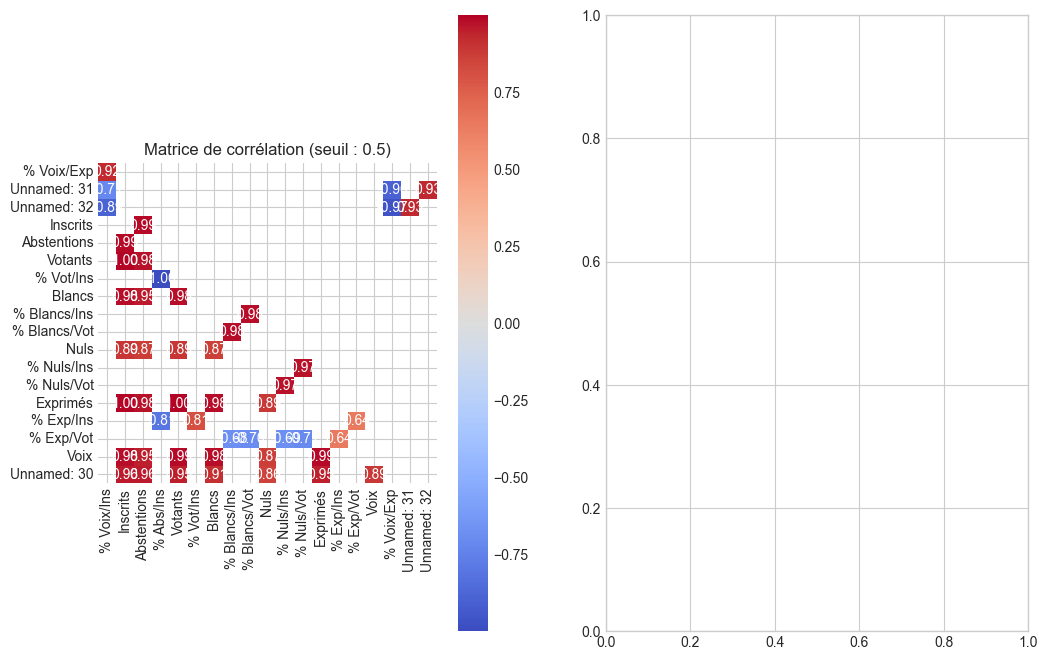

In [27]:
display_correlation_matrix(res_train_df , target=target)

In [18]:
# présélection
# colonnes clairement non informatives à supprimer
col_to_drop_train = ['Unnamed: 27' ,'Unnamed: 26' , 'Unnamed: 28' ,
                'Unnamed: 29' , 'Unnamed: 30','Unnamed: 31' ,
                'Unnamed: 32' ,'Prénom','Sexe','Nom','N°Panneau','Libellé de la commune']

id_train = 'CodeINSEE'

col_to_keep1 , to_holes_train = get_analyse(res_train_df,id_train,col_to_drop_train)

In [19]:
# @title conclusion
write_markdown_conclusion(id_train, to_holes_train, col_to_drop_train, col_to_keep1)


#### Conclusion

* _Identifiant_ : ``'CodeINSEE'``

* _Colonnes avec plus de 60% de valeurs manquantes_ : ``[]``

* _Colonnes à supprimer_ : ``['Unnamed: 27', 'Unnamed: 26', 'Unnamed: 28', 'Unnamed: 29', 'Unnamed: 30', 'Unnamed: 31', 'Unnamed: 32', 'Prénom', 'Sexe', 'Nom', 'N°Panneau', 'Libellé de la commune']``

* _Colonnes à conserver_ : ``['CodeINSEE', 'Libellé du département', 'Etat saisie', 'Inscrits', 'Abstentions', '% Abs/Ins', 'Votants', '% Vot/Ins', 'Blancs', '% Blancs/Ins', '% Blancs/Vot', 'Nuls', '% Nuls/Ins', '% Nuls/Vot', 'Exprimés', '% Exp/Ins', '% Exp/Vot', 'Voix', '% Voix/Ins', '% Voix/Exp']``

----


### niveau de vie

In [20]:
# @title visualisation
visualise(niveau_vie_df)

niveau_vie_df.head(3)

forme : (36572, 4)


,Code Commune,Nom Commune,Niveau de vie Commune,Niveau de vie Département
0,05047,Éourres,10021.250,19202.516
1,26142,Glandage,10215.000,19300.504
2,11317,Rodome,10908.500,17599.733


In [21]:
all_col_niveau_vie = all_columns(niveau_vie_df)


les colonnes sont : 
Index(['Code Commune', 'Nom Commune', 'Niveau de vie Commune',
       'Niveau de vie Département'],
      dtype='object')
 il y'a 4 colonnes dans le dataframe

------------------------------------------------------------------------------------------



In [22]:
# @title présélection
# colonnes clairement non informatives à supprimer
col_to_drop_niveau = []
id_niveau = 'Code Commune'

col_to_keep2 , to_holes_niveau = get_analyse(niveau_vie_df,id_niveau,col_to_drop_niveau)

In [23]:
# @title conclusion
write_markdown_conclusion(id_niveau, to_holes_niveau, col_to_drop_niveau, col_to_keep2)


#### Conclusion

* _Identifiant_ : ``'Code Commune'``

* _Colonnes avec plus de 60% de valeurs manquantes_ : ``[]``

* _Colonnes à supprimer_ : ``[]``

* _Colonnes à conserver_ : ``['Code Commune', 'Nom Commune', 'Niveau de vie Commune', 'Niveau de vie Département']``

----


### communes de frances

In [24]:
# @title visualisation
visualise(communes_df)

communes_df.head(3)

forme : (35010, 39)


,Unnamed: 0,code_insee,nom_standard,nom_sans_pronom,nom_a,nom_de,nom_sans_accent,nom_standard_majuscule,typecom,typecom_texte,reg_code,reg_nom,dep_code,dep_nom,canton_code,canton_nom,epci_code,epci_nom,academie_code,academie_nom,code_postal,codes_postaux,zone_emploi,code_insee_centre_zone_emploi,population,superficie_hectare,superficie_km2,densite,altitude_moyenne,altitude_minimale,altitude_maximale,latitude_mairie,longitude_mairie,latitude_centre,longitude_centre,grille_densite,gentile,url_wikipedia,url_villedereve
0,0,01001,L'Abergement-Clémenciat,Abergement-Clémenciat,à Abergement-Clémenciat,de l'Abergement-Clémenciat,l-abergement-clemenciat,L'ABERGEMENT-CLÉMENCIAT,COM,commune,84,Auvergne-Rhône-Alpes,01,Ain,0108,Châtillon-sur-Chalaronne,200069193,CC de la Dombes,10,Lyon,1400,01400,8405.000,01053,779,1565,16,48.700,242,206.000,272.000,46.153,4.926,46.153,4.926,Rural à habitat dispersé,NaN,https://fr.wikipedia.org/wiki/fr:L'Abergement-...,https://villedereve.fr/ville/01001-l-abergemen...
1,1,01002,L'Abergement-de-Varey,Abergement-de-Varey,à Abergement-de-Varey,de l'Abergement-de-Varey,l-abergement-de-varey,L'ABERGEMENT-DE-VAREY,COM,commune,84,Auvergne-Rhône-Alpes,01,Ain,0101,Ambérieu-en-Bugey,240100883,CC de la Plaine de l'Ain,10,Lyon,1640,01640,8405.000,01053,256,912,9,27.100,483,290.000,748.000,46.009,5.428,46.009,5.428,Rural à habitat dispersé,"Abergementais, Abergementaises",https://fr.wikipedia.org/wiki/fr:L'Abergement-...,https://villedereve.fr/ville/01002-l-abergemen...
2,2,01004,Ambérieu-en-Bugey,Ambérieu-en-Bugey,à Ambérieu-en-Bugey,d'Ambérieu-en-Bugey,amberieu-en-bugey,AMBÉRIEU-EN-BUGEY,COM,commune,84,Auvergne-Rhône-Alpes,01,Ain,0101,Ambérieu-en-Bugey,240100883,CC de la Plaine de l'Ain,10,Lyon,1500,"01500, 01501, 01504, 01503, 01502, 01505, 01506",8405.000,01053,14134,2448,24,570.500,379,237.000,753.000,45.961,5.373,45.961,5.373,Centres urbains intermédiaires,"Ambarrois, Ambarroises",https://fr.wikipedia.org/wiki/fr:Ambérieu-en-B...,https://villedereve.fr/ville/01004-amberieu-en...


In [25]:
# @title all colonnes
all_col_commune = all_columns(communes_df)

les colonnes sont : 
Index(['Unnamed: 0', 'code_insee', 'nom_standard', 'nom_sans_pronom', 'nom_a',
       'nom_de', 'nom_sans_accent', 'nom_standard_majuscule', 'typecom',
       'typecom_texte', 'reg_code', 'reg_nom', 'dep_code', 'dep_nom',
       'canton_code', 'canton_nom', 'epci_code', 'epci_nom', 'academie_code',
       'academie_nom', 'code_postal', 'codes_postaux', 'zone_emploi',
       'code_insee_centre_zone_emploi', 'population', 'superficie_hectare',
       'superficie_km2', 'densite', 'altitude_moyenne', 'altitude_minimale',
       'altitude_maximale', 'latitude_mairie', 'longitude_mairie',
       'latitude_centre', 'longitude_centre', 'grille_densite', 'gentile',
       'url_wikipedia', 'url_villedereve'],
      dtype='object')
 il y'a 39 colonnes dans le dataframe

------------------------------------------------------------------------------------------



A première vu , on n'a pas besoin des
* url vers les sites internet des communes  c'est à dire ``url_wikipedia`` , ``url_ville``
* ``typecom`` et ``typecom_texte`` sont des colonnes constantes : on est toujours censé avoir à faire à des communes
* pas besoin de tous les type de noms de la communes , un seul suffira `nom_standard` , mais il est aussi renseigné dans `Niveau de vie`
* unamed ici represente un index donc inutile aussi
* on peut regrouper ` 'altitude_moyenne'`, `'altitude_minimale'`,
       `'altitude_maximale'` en  un ou deux indices d'altitude , idem pour les ``latitude...`` et ``longitute...``
* supprimer les infos d'identification (x_code , x_nom) sur les départements et régions , leurs codes sont déjà fourni dans ``MDB-insee-divers`` ce dernier ayant plus d'échantillons

In [26]:
# @title présélection
# colonnes jugées non informatives à supprimer

col_to_drop_commune = ['url_wikipedia','url_villedereve',
                       'typecom','typecom_texte',
                       'nom_standard','nom_a','nom_de',
                       'nom_sans_pronom','gentile',
                       'nom_sans_accent','nom_standard_majuscule',
                       'superficie_hectare','Unnamed: 0',
                       'academie_nom','codes postaux',
                       'longitude_centre','latitude_centre',
                       'reg_nom','dep_nom','canton_nom','epci_nom']
id_commune = 'code_insee'

col_to_keep3 , to_holes_commune = get_analyse(communes_df,id_commune,col_to_drop_commune)

In [27]:
# @title conclusion
write_markdown_conclusion(id_commune, to_holes_commune, col_to_drop_commune, col_to_keep3)


#### Conclusion

* _Identifiant_ : ``'code_insee'``

* _Colonnes avec plus de 60% de valeurs manquantes_ : ``[]``

* _Colonnes à supprimer_ : ``['url_wikipedia', 'url_villedereve', 'typecom', 'typecom_texte', 'nom_standard', 'nom_a', 'nom_de', 'nom_sans_pronom', 'gentile', 'nom_sans_accent', 'nom_standard_majuscule', 'superficie_hectare', 'Unnamed: 0', 'academie_nom', 'codes postaux', 'longitude_centre', 'latitude_centre', 'reg_nom', 'dep_nom', 'canton_nom', 'epci_nom']``

* _Colonnes à conserver_ : ``['code_insee', 'reg_code', 'dep_code', 'canton_code', 'epci_code', 'academie_code', 'code_postal', 'codes_postaux', 'zone_emploi', 'code_insee_centre_zone_emploi', 'population', 'superficie_km2', 'densite', 'altitude_moyenne', 'altitude_minimale', 'altitude_maximale', 'latitude_mairie', 'longitude_mairie', 'grille_densite']``

----


### age-insee

#### première analyse visuelle

In [28]:
# @title visualisation
visualise(age_df)

age_df.head(3)

forme : (34980, 26)


,INSEE,NOM,EPCI,DEP,REG,F0-2,F3-5,F6-10,F11-17,F18-24,F25-39,F40-54,F55-64,F65-79,F80+,Unnamed: 15,H0-2,H3-5,H6-10,H11-17,H18-24,H25-39,H40-54,H55-64,H65-79,H80+
0,1001,L'Abergement-Clémenciat,200069193,D1,R84,13.414,12.509,19.214,37.182,14.062,70.119,84.512,60.032,64.311,20.164,NaN,18.070,14.403,34.540,40.257,14.231,72.498,81.849,61.039,55.240,18.353
1,1002,L'Abergement-de-Varey,240100883,D1,R84,2.994,6.050,12.232,11.869,5.202,20.498,33.975,12.365,12.419,7.027,NaN,2.994,6.116,6.953,22.349,6.394,19.540,37.479,10.977,15.687,8.879
2,1004,Ambérieu-en-Bugey,240100883,D1,R84,294.668,245.153,382.801,599.105,680.831,1451.111,1268.502,903.062,1064.992,517.133,NaN,256.304,289.985,485.793,613.182,669.385,1542.699,1238.120,782.771,750.040,252.364


In [29]:
# @title Présélection
# visuellement
col_to_drop_age = ['NOM']
id_age = 'INSEE'
all_col_age = age_df.columns.tolist()
col_to_keep4 , to_holes_age = get_analyse(age_df,id_age,col_to_drop_age)


In [30]:
col_to_drop_age += to_holes_age
print(col_to_drop_age)


['NOM', 'Unnamed: 15']


A defaut d'avoir toutes les tranches d'âge pour chaque sexe , on regroupe les nombres d'hommes et femmes de chaque tranche pour avoir moins de variables:
* Sur le plan social  :
    * `% Mineurs` (0 - 17),
    * `% Adultes`(18-54) ,
    * `% Seniors`(55-79) ,
    * `% Tres_seniors`(80+)
* sur le plan économique :
    *`% Travailleurs` ceux qui ont l'age de potentiellement travailler
    * `% Retraites`  ceux qu'on a jugés ne plus pouvoir travailler car ont plus de `64` ans

#### Regroupement des âges

In [31]:
age_groups = age_df[age_df.columns[:5]]

# population total
col_genre = sub(sub(all_col_age,col_to_drop_age),age_df.columns[:5].tolist())
col_hom = col_genre[10:]
age_groups['Population'] = age_df[col_genre].sum(axis=1)


In [32]:
#--------------------------------
# Regroupement par cycle de vie
#-------------------------------

# les mineurs
age_groups['% Mineurs'] = (age_df['F0-2'] + age_df['F3-5'] +age_df['F6-10']+age_df['F11-17'] + age_df['H0-2'] + age_df['H3-5'] + age_df['H0-2']+age_df['H6-10']+age_df['F11-17'] ) / age_groups['Population'] * 100

# les adultes
age_groups['% Adultes'] = (age_df['F18-24'] + age_df['F25-39'] + age_df['F40-54']+age_df['H18-24']+age_df['H25-39'] + age_df['H40-54']) / age_groups['Population'] * 100


# les agés
age_groups['% Seniors'] = (age_df['F55-64'] + age_df['F65-79'] + age_df['H55-64'] + age_df['H65-79']) / age_groups['Population'] * 100


# les très agés
age_groups['% Tres_Seniors'] = (age_df['F80+'] + age_df['H80+']) / age_groups['Population'] * 100

# les retraités
age_groups['% Retraites'] = (age_df['F65-79'] + age_df['H65-79'] + age_df['F80+'] + age_df['H80+']) / age_groups['Population'] * 100

# travailleurs potentiels
age_groups['% Travailleurs'] = (age_groups['% Adultes'] + age_groups['% Seniors'] + age_groups['% Tres_Seniors'] - age_groups['% Retraites']) / age_groups['Population'] * 100

# ratio hommes/femmes
age_groups['rH/F'] = ( age_df[col_hom].sum(axis=1)  / age_df[col_genre[:10]].sum(axis=1) )

age_groups.to_csv("age_groups.csv",index=False)
age_groups.head(3)


,INSEE,NOM,EPCI,DEP,REG,Population,% Mineurs,% Adultes,% Seniors,% Tres_Seniors,% Retraites,% Travailleurs,rH/F
0,1001,L'Abergement-Clémenciat,200069193,D1,R84,806.000,25.383,41.845,29.854,4.779,19.611,7.055,1.038
1,1002,L'Abergement-de-Varey,240100883,D1,R84,262.000,24.455,46.980,19.637,6.071,16.798,21.332,1.102
2,1004,Ambérieu-en-Bugey,240100883,D1,R84,14288.000,23.861,47.947,24.502,5.386,18.089,0.418,0.929


#### mise à jour et conclusion

In [33]:
col_to_drop_age = []
colt_to_keep4 = sub(all_col_age,col_to_drop_age)


### MDB-INSEE-Divers

#### première analyse visuelle

In [34]:
# @title visualisation
visualise(insee_divers_df)

insee_divers_df.head(3)

forme : (36677, 101)


,CODGEO,Nb Pharmacies et parfumerie,Dynamique Entrepreneuriale,Dynamique Entrepreneuriale Service et Commerce,Synergie Médicale COMMUNE,Orientation Economique,Indice Fiscal Partiel,Score Fiscal,Indice Evasion Client,Score Evasion Client,Indice Synergie Médicale,Score Synergie Médicale,SEG Croissance POP,LIBGEO,REG,DEP,Nb Omnipraticiens BV,Nb Infirmiers Libéraux BV,Nb dentistes Libéraux BV,Nb pharmaciens Libéraux BV,Densité Médicale BV,Score équipement de santé BV,Indice Démographique,Score Démographique,Indice Ménages,Score Ménages,Population,Evolution Population,Evolution Pop %,Nb Ménages,Nb Résidences Principales,Nb propriétaire,Nb Logement,Nb Résidences Secondaires,Nb Log Vacants,Nb Occupants Résidence Principale,Nb Femme,Nb Homme,Nb Mineurs,Nb Majeurs,Nb Etudiants,Nb Entreprises Secteur Services,Nb Entreprises Secteur Commerce,Nb Entreprises Secteur Construction,Nb Entreprises Secteur Industrie,Nb Création Enteprises,Nb Création Industrielles,Nb Création Construction,Nb Création Commerces,Nb Création Services,Moyenne Revenus Fiscaux Départementaux,Moyenne Revenus Fiscaux Régionaux,Dep Moyenne Salaires Horaires,Dep Moyenne Salaires Cadre Horaires,Dep Moyenne Salaires Prof Intermédiaire Horaires,Dep Moyenne Salaires Employé Horaires,Dep Moyenne Salaires Ouvrié Horaires,Reg Moyenne Salaires Horaires,Reg Moyenne Salaires Cadre Horaires,Reg Moyenne Salaires Prof Intermédiaire Horaires,Reg Moyenne Salaires Employé Horaires,Reg Moyenne Salaires Ouvrié Horaires,Valeur ajoutée régionale,Urbanité Ruralité,Score Urbanité,Nb Atifs,Nb Actifs Salariés,Nb Actifs Non Salariés,Nb Logement Secondaire et Occasionnel,Nb Hotel,Capacité Hotel,Nb Camping,Capacité Camping,Dynamique Démographique BV,Taux étudiants,Taux Propriété,Dynamique Démographique INSEE,Capacité Fisc,Capacité Fiscale,Moyenne Revnus fiscaux,Taux Evasion Client,"Nb Education, santé, action sociale",Nb Services personnels et domestiques,"Nb Santé, action sociale",Nb Industries des biens intermédiaires,Nb de Commerce,Nb de Services aux particuliers,"Nb institution de Education, santé, action sociale, administration",PIB Régionnal,SEG Environnement Démographique Obsolète,Score Croissance Population,Score Croissance Entrepreneuriale,Score VA Région,Score PIB,Environnement Démographique,Fidélité,SYN MEDICAL,Seg Cap Fiscale,Seg Dyn Entre,DYN SetC,CP
0,01001,0.000,57.000,23.000,114,Bassin Industriel,101.939,59.041,0.000,0.000,114.567,0.135,en croissance démographique,L' Abergement-Clémenciat,82,01,9,14,7,7,0.093,4,44.198,0.034,37.220,0.022,725,16,2,247,248,196,289,32,9,728,694,714,909,499,51,7.000,11.000,2.000,2.000,4.000,0.000,2.000,1.000,1.000,12509,10458,11.410,21.964,12.559,8.743,9.269,11.873,21.788,12.704,8.783,9.301,86957.458,Com rurale < 2 000 m habts,0.000,295.000,254.000,41.000,32.000,0.000,0.000,0.000,0.000,1.Accroissement par excédent naturel et migrat...,0,67,-1,117,117,11483.500,0,3.000,1.000,0.000,9364,9350,3372,15105,173681,Zone rurale en croissance démographique,72.131,0.016,32.426,33.838,Bassin Industriel en croissance démographique,Pop Sédentaire,Synergie Médicale,Fiscalité moyenne,Faible dynamique,Faible Dynamique Serv et Com,01
1,01002,0.000,45.000,4.000,143,Bassin Résidentiel,101.939,59.041,0.000,0.000,143.711,0.174,en croissance démographique,L' Abergement-de-Varey,82,01,31,36,18,18,0.099,4,10.181,0.008,10.096,0.006,167,4,2,67,67,61,142,71,4,168,162,164,202,124,5,4.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,1.000,12509,10458,11.410,21.964,12.559,8.743,9.269,11.873,21.788,12.704,8.783,9.301,86957.458,Com rurale < 2 000 m habts,0.000,57.000,49.000,8.000,71.000,0.000,0.000,0.000,0.000,1.Accroissement par excédent naturel et migrat...,0,42,0,110,110,11483.500,0,0.000,0.000,0.000,9364,9350,3372,15105,173681,Zone rurale en croissance démographique,72.131,0.002,32.426,33.838,Bassin Résidentiel en croissance démographique,Pop Sédentaire,Forte Synergie Médicale,Fiscalité moyenne,Faible dynamique,Faible Dynamique Serv et Com,01
2,01004,0.000,634.000,828.000,366,Bassin R

In [35]:
# @title affichage des colonnes
all_col_insee_divers = all_columns(insee_divers_df)

les colonnes sont : 
Index(['CODGEO', 'Nb Pharmacies et parfumerie', 'Dynamique Entrepreneuriale',
       'Dynamique Entrepreneuriale Service et Commerce',
       'Synergie Médicale COMMUNE', 'Orientation Economique',
       'Indice Fiscal Partiel', 'Score Fiscal', 'Indice Evasion Client',
       'Score Evasion Client',
       ...
       'Score Croissance Entrepreneuriale', 'Score VA Région', 'Score PIB',
       'Environnement Démographique', 'Fidélité', 'SYN MEDICAL',
       'Seg Cap Fiscale', 'Seg Dyn Entre', 'DYN SetC', 'CP'],
      dtype='object', length=101)
 il y'a 101 colonnes dans le dataframe

------------------------------------------------------------------------------------------



#### regroupement

In [36]:
# @title présélection
id_mdb = 'CODGEO'
# colonnes jugées non informatives ou trop difficile à manipuler
col_to_drop_mdb = ['Nb Résidences Principales','Nb Log Vacants' ,
                   'Nb Résidences Secondaires',
                   'Score démographique' , 'Score Ménages' ,
                   'Evolution Pop %','Score Fiscal',
                   'Score Evasion Client','Score Synergie Médicale',
                   'Population','Nb Logement Secondaires',
                   'Capacité Camping', 'Capacité Hotel',
                   'Dynamique Démographique BV', 'Capacité Fisc',
                   'CP' , 'Urbanité Ruralité' , 'SEG Environnement Démographique Obsolète']
# les colonnes qui on été regroupées
HF = ['Nb Homme' , 'Nb Femme']

mM = ['Nb Mineurs' , 'Nb Majeurs']

Nb_entreprises = ['Nb Entreprises Secteur Commerce' ,
                  'Nb Entreprises Secteur Construction',
                  'Nb Entreprises Secteur Industrie' ,
                  'Nb Entreprises Secteur Services']

Nb_medecins = ['Nb Omnipraticiens BV' ,
             'Nb Infirmiers Libéraux BV',
             'Nb dentistes Libéraux BV',
             'Nb pharmaciens Libéraux BV']

Indice_creation_eco = ['Nb Création Enteprises' ,
                    'Nb Création Industrielles',
                    'Nb Création Construction',
                    'Nb Création Commerces',
                    'Nb création Services']

Indice_fiscal = ['Moyenne Revenus Fiscaux Départementaux',
                 'Moyenne Revenus Fiscaux Régionaux']

Indice_social =['Nb Education, santé, action sociale',
                'Nb Santé, action sociale',
                'Nb institution de Education, santé, action sociale, administration']

Indice_services = ['Nb Services personnels et domestiques',
                   'Nb Industries des biens intermédiaires',
                   'Nb de Commerce',
                   'Nb de Services aux particuliers']

Indice_salaire_global = ['Dep Moyenne Salaires Horaires',
                         'Reg Moyenne Salaires Horaires',]

indice_salaire_csp = ['Dep Moyenne Salaires Cadre Horaires',
                      'Reg Moyenne Salaires Cadre Horaires',
                      'Dep Moyenne Salaires Prof Intermédiaire Horaires',
                      'Reg Moyenne Salaires Prof Intermédiaire Horaires',
                      'Dep Moyenne Salaires Employé Horaires',
                      'Reg Moyenne Salaires Employé Horaires',
                      'Dep Moyenne Salaires Ouvrié Horaires',
                      'Reg Moyenne Salaires Ouvrié Horaires']

dict_indice_salaire = {
    'indice_salaire_global': Indice_salaire_global,
    **{'indice_salaire_'+str(i) : indice_salaire_csp[i:i+2] for i in range(0, len(indice_salaire_csp), 2)}
}

col_to_drop_mdb += HF + mM + Nb_entreprises + Nb_medecins + Indice_creation_eco + Indice_fiscal + Indice_salaire_global + indice_salaire_csp + Indice_services + Indice_social

col_to_keep5 = sub(all_col_insee_divers,col_to_drop_mdb)

# ...existing code...

# Dictionnaire de correspondance pour les nouveaux noms
nouveaux_noms = {
    'indice_salaire_0': 'indice_salaire_cadre',
    'indice_salaire_2': 'indice_salaire_prof',
    'indice_salaire_4': 'indice_salaire_employé',
    'indice_salaire_6': 'indice_salaire_ouvrié'
}

for old_key, new_key in nouveaux_noms.items():
    if old_key in dict_indice_salaire:
        dict_indice_salaire[new_key] = dict_indice_salaire.pop(old_key)

# Vérification
for k, v in dict_indice_salaire.items():
    print(f"{k} : {v}")
# ...existing code...

indice_salaire_global : ['Dep Moyenne Salaires Horaires', 'Reg Moyenne Salaires Horaires']
indice_salaire_cadre : ['Dep Moyenne Salaires Cadre Horaires', 'Reg Moyenne Salaires Cadre Horaires']
indice_salaire_prof : ['Dep Moyenne Salaires Prof Intermédiaire Horaires', 'Reg Moyenne Salaires Prof Intermédiaire Horaires']
indice_salaire_employé : ['Dep Moyenne Salaires Employé Horaires', 'Reg Moyenne Salaires Employé Horaires']
indice_salaire_ouvrié : ['Dep Moyenne Salaires Ouvrié Horaires', 'Reg Moyenne Salaires Ouvrié Horaires']


In [37]:
mdb_df = insee_divers_df[col_to_keep5].copy()

# nombre d'entreprises
mdb_df['Nb Entreprises'] = insee_divers_df[Nb_entreprises].sum(axis=1)

# nombre de médecins
mdb_df['Nb Medecins'] = insee_divers_df[Nb_medecins].sum(axis=1)
mdb_df.head(3)

# ratio du nombre d'hommes par rapport au femmes
mdb_df['rH/F'] = insee_divers_df[HF[0]] / insee_divers_df[HF[1]]

# ratio du nombre de mineurs par par rapport au majeurs
mdb_df['rm/M'] = insee_divers_df[mM[0]] / insee_divers_df[mM[1]]

# Indice salariax
for k , v in dict_indice_salaire.items():
    mdb_df[k] = insee_divers_df[v[0]]/insee_divers_df[v[1]]

# indice social
mdb_df['indice_social'] = insee_divers_df[Indice_social].sum(axis=1)

# indice services
mdb_df['indice_services'] = insee_divers_df[Indice_services].sum(axis=1)

mdb_df.to_csv("MDB_groupe.csv",index=False)
mdb_df.head(3)

,CODGEO,Nb Pharmacies et parfumerie,Dynamique Entrepreneuriale,Dynamique Entrepreneuriale Service et Commerce,Synergie Médicale COMMUNE,Orientation Economique,Indice Fiscal Partiel,Indice Evasion Client,Indice Synergie Médicale,SEG Croissance POP,LIBGEO,REG,DEP,Densité Médicale BV,Score équipement de santé BV,Indice Démographique,Score Démographique,Indice Ménages,Evolution Population,Nb Ménages,Nb propriétaire,Nb Logement,Nb Occupants Résidence Principale,Nb Etudiants,Nb Création Services,Valeur ajoutée régionale,Score Urbanité,Nb Atifs,Nb Actifs Salariés,Nb Actifs Non Salariés,Nb Logement Secondaire et Occasionnel,Nb Hotel,Nb Camping,Taux étudiants,Taux Propriété,Dynamique Démographique INSEE,Capacité Fiscale,Moyenne Revnus fiscaux,Taux Evasion Client,PIB Régionnal,Score Croissance Population,Score Croissance Entrepreneuriale,Score VA Région,Score PIB,Environnement Démographique,Fidélité,SYN MEDICAL,Seg Cap Fiscale,Seg Dyn Entre,DYN SetC,Nb Entreprises,Nb Medecins,rH/F,rm/M,indice_salaire_global,indice_salaire_cadre,indice_salaire_prof,indice_salaire_employé,indice_salaire_ouvrié,indice_social,indice_services
0,01001,0.000,57.000,23.000,114,Bassin Industriel,101.939,0.000,114.567,en croissance démographique,L' Abergement-Clémenciat,82,01,0.093,4,44.198,0.034,37.220,16,247,196,289,728,51,1.000,86957.458,0.000,295.000,254.000,41.000,32.000,0.000,0.000,0,67,-1,117,11483.500,0,173681,72.131,0.016,32.426,33.838,Bassin Industriel en croissance démographique,Pop Sédentaire,Synergie Médicale,Fiscalité moyenne,Faible dynamique,Faible Dynamique Serv et Com,22.000,37,1.029,1.822,0.961,1.008,0.989,0.995,0.997,15108.000,22087.000
1,01002,0.000,45.000,4.000,143,Bassin Résidentiel,101.939,0.000,143.711,en croissance démographique,L' Abergement-de-Varey,82,01,0.099,4,10.181,0.008,10.096,4,67,61,142,168,5,1.000,86957.458,0.000,57.000,49.000,8.000,71.000,0.000,0.000,0,42,0,110,11483.500,0,173681,72.131,0.002,32.426,33.838,Bassin Résidentiel en croissance démographique,Pop Sédentaire,Forte Synergie Médicale,Fiscalité moyenne,Faible dynamique,Faible Dynamique Serv et Com,5.000,103,1.012,1.629,0.961,1.008,0.989,0.995,0.997,15105.000,22086.000
2,01004,0.000,634.000,828.000,366,Bassin Résidentiel,101.939,248.455,367.821,en croissance démographique,Ambérieu-en-Bugey,82,01,0.099,4,696.921,0.538,699.199,512,4640,1968,5184,11015,904,38.000,86957.458,37.500,4556.000,4203.000,353.000,135.000,2.000,0.000,0,37,-55,250,11483.500,2,173681,72.951,0.385,32.426,33.838,Bassin Résidentiel en croissance démographique,Pop Mobile,Forte Synergie Médicale,Fiscalité moyenne,Dynamique Economique,Bonne Dynamique Entreprise Serv et Com,809.000,103,0.958,1.583,0.961,1.008,0.989,0.995,0.997,15336.000,22127.000


* pas besoin du `Nb Résidences Principales` et `Nb Résidences Secondaires` , `Nb log Vacants`  car leur somme = `Nb Logement`
* on peut regrouper les colonnes `Moyenne Revenus Fiscaux Départementaux` à `Moyenne Revenus Fiscaux Régionaux` en `indice fiscal` par  Indice_fiscal_dep $= \frac{Moyenne Revenus Fiscaux Départementaux}{Moyenne Revenus Fiscaux Régionaux}$

* regrouper  `Dep Moyenne Salaires Horaires` à `Reg Moyenne Salaires Horaires`  en indice salariaux -> utiliser la méthodes ACP apprament qui permet de les réduire à 2 indices synthétiques `CP1` et `CP2`

## 1.3 Fusion des sources fournies et nettoyage

### resultat de la préanalyse

In [38]:
# @title colonnes à supprimer , avec trop de valeurs manquantes et à conserver

cols_to_drop = col_to_drop_train + col_to_drop_niveau + col_to_drop_commune + col_to_drop_age + col_to_drop_mdb
print(f"{len(cols_to_drop)} colonnes(s) à supprimer")

cols_to_keep = col_to_keep1 + col_to_keep2 + col_to_keep3 + col_to_keep4 + col_to_keep5
print(f"{len(cols_to_keep)} colonne(s) à conserver y compris les identifiants")


87 colonnes(s) à supprimer
117 colonne(s) à conserver y compris les identifiants


### fusion et extration des données

In [39]:
def safe_feature_selection(X, selected_features):
    """
    Retourne les colonnes de X correspondant aux selected_features valides.
    """
    return X[[feat for feat in selected_features if feat in X.columns]]

merge_list = [(niveau_vie_df , id_niveau),
              (communes_df , id_commune),
              (age_groups , id_age),
              (mdb_df , id_mdb)]

#fonction de fussion
def prepare_datasets(train_data,
                     test_data,
                     merge_list ,
                     base_id = id_train,
                     cols_to_drop = cols_to_drop,
                     verbose=False):
    """
    Fonction pour préparer et fusionner les datasets pour la modélisation
    """
    #Extraire les données de Macron
    train_features = train_data[train_data['Nom']=='MACRON'].copy()
    test_features = test_data.copy()

    # harmoniser les colonnes d'identification
    train_features['CodeINSEE'] = train_features['CodeINSEE'].astype(str).str.zfill(5)
    test_features['CodeINSEE'] = test_features['CodeINSEE'].astype(str).str.zfill(5)

    for i , (df , id_col) in enumerate(merge_list):
        # Vérifier si la colonne d'identification est présente dans le DataFrame
        if id_col not in df.columns:
            raise ValueError(f"La colonne d'identification '{id_col}' n'est pas présente dans le DataFrame à l'index {i}.")

        # Assurer que la colonne d'identification est au format string avec padding
        df[id_col] = df[id_col].astype(str).str.zfill(5)

        # nombre d'échantillons avant la fusion
        n_samples_before = train_features.shape[0]

        # Fusionner les DataFrames sur la colonne d'identification
        train_features = pd.merge(train_features, df, left_on=base_id, right_on=id_col, how='left')

        test_features = pd.merge(test_features, df, left_on=base_id, right_on=id_col, how='left')

        # nombre d'échantillons après la fusion
        n_samples_after = train_features.shape[0]

        assert n_samples_before == n_samples_after, f"Erreur de fusion : le nombre d'échantillons a changé après la fusion avec {id_col}."

        # supprimer l'identifiant
        if id_col != base_id:
            train_features = train_features.drop(columns=[id_col], axis=1, errors='ignore')
            test_features = test_features.drop(columns=[id_col], axis=1, errors='ignore')
    #-----------------------------------------------------------------
    # Supprimer les colonnes non informatives
    train_features = train_features.drop(columns=cols_to_drop, axis=1, errors='ignore')
    test_features = test_features.drop(columns=cols_to_drop, axis=1, errors='ignore')
    #-----------------------------------------------------------------
    # Supprimer les colonnes d'identification
    train_features = train_features.drop(columns=IDs, axis=1 , errors='ignore')

    if verbose :
        missing1 = ((train_data.isnull().sum()/ train_data.shape[0]).sum()/train_data.shape[1] )* 100
        missing2 = ((train_features.isnull().sum()/ train_features.shape[0]).sum()/train_features.shape[1] )* 100
        #-------------------------------------------------------------
        print(f" {train_features.shape[1]} colonnes vs {train_data.shape[1]} avant la fusion\n")
        print(f" {len(cols_to_drop) + len(merge_list) + 1} colonnes supprimées pendant la fusion \n")
        print(f" \n{train_features.shape[0]} lignes vs {train_data.shape[0]} avant la fusion\n")
        print(f" \n{missing2}% de valeurs manquantes vs {missing1}% avant la fusion")


    return train_features, test_features


In [40]:
train_data , test_data = prepare_datasets(res_train_df, res_test_df,
                                          merge_list,
                                          base_id = id_train,
                                          cols_to_drop = cols_to_drop,
                                          verbose=True)

print(f"forme du train_data : {train_data.shape}")
print(f"forme du test_data : {test_data.shape}")
test_data.head(3)

 111 colonnes vs 32 avant la fusion

 92 colonnes supprimées pendant la fusion 

 
20892 lignes vs 20892 avant la fusion

 
0.13070221283891595% de valeurs manquantes vs 0.0% avant la fusion
forme du train_data : (20892, 111)
forme du test_data : (13928, 96)


,CodeINSEE,Libellé du département,Etat saisie,Inscrits,Nom Commune,Niveau de vie Commune,Niveau de vie Département,reg_code,dep_code,canton_code,epci_code,academie_code,code_postal,codes_postaux,zone_emploi,code_insee_centre_zone_emploi,population,superficie_km2,densite,altitude_moyenne,altitude_minimale,altitude_maximale,latitude_mairie,longitude_mairie,grille_densite,NOM,EPCI,DEP_x,REG_x,% Mineurs,% Adultes,% Seniors,% Tres_Seniors,% Retraites,% Travailleurs,rH/F_x,Nb Pharmacies et parfumerie,Dynamique Entrepreneuriale,Dynamique Entrepreneuriale Service et Commerce,Synergie Médicale COMMUNE,Orientation Economique,Indice Fiscal Partiel,Indice Evasion Client,Indice Synergie Médicale,SEG Croissance POP,LIBGEO,REG_y,DEP_y,Densité Médicale BV,Score équipement de santé BV,Indice Démographique,Score Démographique,Indice Ménages,Evolution Population,Nb Ménages,Nb propriétaire,Nb Logement,Nb Occupants Résidence Principale,Nb Etudiants,Nb Création Services,Valeur ajoutée régionale,Score Urbanité,Nb Atifs,Nb Actifs Salariés,Nb Actifs Non Salariés,Nb Logement Secondaire et Occasionnel,Nb Hotel,Nb Camping,Taux étudiants,Taux Propriété,Dynamique Démographique INSEE,Capacité Fiscale,Moyenne Revnus fiscaux,Taux Evasion Client,PIB Régionnal,Score Croissance Population,Score Croissance Entrepreneuriale,Score VA Région,Score PIB,Environnement Démographique,Fidélité,SYN MEDICAL,Seg Cap Fiscale,Seg Dyn Entre,DYN SetC,Nb Entreprises,Nb Medecins,rH/F_y,rm/M,indice_salaire_global,indice_salaire_cadre,indice_salaire_prof,indice_salaire_employé,indice_salaire_ouvrié,indice_social,indice_services
0,01001,Ain,Complet,643,L'Abergement-Clémenciat,22130.000,22343.575,84,01,0108,200069193,10,1400,01400,8405.000,01053,779,16,48.700,242,206.000,272.000,46.153,4.926,Rural à habitat dispersé,L'Abergement-Clémenciat,200069193,D1,R84,25.383,41.845,29.854,4.779,19.611,7.055,1.038,0.000,57.000,23.000,114.000,Bassin Industriel,101.939,0.000,114.567,en croissance démographique,L' Abergement-Clémenciat,82.000,01,0.093,4.000,44.198,0.034,37.220,16.000,247.000,196.000,289.000,728.000,51.000,1.000,86957.458,0.000,295.000,254.000,41.000,32.000,0.000,0.000,0.000,67.000,-1.000,117.000,11483.500,0.000,173681.000,72.131,0.016,32.426,33.838,Bassin Industriel en croissance démographique,Pop Sédentaire,Synergie Médicale,Fiscalité moyenne,Faible dynamique,Faible Dynamique Serv et Com,22.000,37.000,1.029,1.822,0.961,1.008,0.989,0.995,0.997,15108.000,22087.000
1,01002,Ain,Complet,213,L'Abergement-de-Varey,23213.000,22343.575,84,01,0101,240100883,10,1640,01640,8405.000,01053,256,9,27.100,483,290.000,748.000,46.009,5.428,Rural à habitat dispersé,L'Abergement-de-Varey,240100883,D1,R84,24.455,46.980,19.637,6.071,16.798,21.332,1.102,0.000,45.000,4.000,143.000,Bassin Résidentiel,101.939,0.000,143.711,en croissance démographique,L' Abergement-de-Varey,82.000,01,0.099,4.000,10.181,0.008,10.096,4.000,67.000,61.000,142.000,168.000,5.000,1.000,86957.458,0.000,57.000,49.000,8.000,71.000,0.000,0.000,0.000,42.000,0.000,110.000,11483.500,0.000,173681.000,72.131,0.002,32.426,33.838,Bassin Résidentiel en croissance démographique,Pop Sédentaire,Forte Synergie Médicale,Fiscalité moyenne,Faible dynamique,Faible Dynamique Serv et Com,5.000,103.000,1.012,1.629,0.961,1.008,0.989,0.995,0.997,15105.000,22086.000
2,01004,Ain,Complet,8763,Ambérieu-en-Bugey,19554.000,22343.575,84,01,0101,240100883,10,1500,"01500, 01501, 01504, 01503, 01502, 01505, 01506",8405.000,01053,14134,24,570.500,379,237.000,753.000,45.961,5.373,Centres urbains intermédiaires,Ambérieu-en-Bugey,240100883,D1,R84,23.861,47.947,24.502,5.386,18.089,0.418,0.929,0.000,634.000,828.000,366.000,Bassin Résidentiel,101.939,248.455,367.821,en croissance démographique,Ambérieu-en-Bugey,82.000,01,0.099,4.000,696.921,0.538,699.199,512.000,4640.000,1968.000,5184.000,11015.000,904.000,38.000,86957.458,37.500,4556.000,4203.000,353.000,135.000,2.000,0.000,0.000,37.000,-55.000,250.000,11483.500,2.000,173681.000,72.951,0.385,32.426,33.838,Bassin Résidentiel

In [41]:
X = train_data.drop(columns=[target], axis=1,errors='ignore')
y = train_data[target]

print(X.info())
print(f"forme des prédicteurs : {X.shape}")
print(f"forme de la cible : {y.shape}")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20892 entries, 0 to 20891
Columns: 110 entries, Libellé du département to indice_services
dtypes: float64(74), int64(13), object(23)
memory usage: 17.5+ MB
None
forme des prédicteurs : (20892, 110)
forme de la cible : (20892,)


# 2. Prétraitement , Pipeline et Selection automatique de features

----

## 2.1 Création du pipelines de prétraitement

In [42]:
def get_preprocessor(data,features=None):
    """
    Crée un préprocesseur complet avec gestion des valeurs infinies, manquantes et aberrantes
    """
    X=data.copy()
    # Remplacer les valeurs infinies par NaN
    X = X.replace([np.inf, -np.inf], np.nan)

    if features is not None:
        X = X[features]

    numeric_features = X.select_dtypes(include=['int64', 'float64',np.number]).columns
    categorical_features = X.select_dtypes(include=['object', 'category','bool']).columns

    # conversion des colonnes catégorielles en type str pour éviter les type mixte
    X[categorical_features] = X[categorical_features].astype(str)


    # Pipeline pour les variables numériques
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', RobustScaler())
    ] ,   memory='cache_directory')

    # Pipeline pour les variables catégorielles
    categorical_transformer = Pipeline(
        steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder( sparse_output=False, handle_unknown='ignore'))
        ])

    # Combinaison des transformateurs
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ],
        remainder = 'drop',
        verbose_feature_names_out=False,
        n_jobs=-1)

    return preprocessor


## 2.2 Selection automatique des features

### 2.2.1 Selection grossière automatique avec xgboost


In [43]:
def remove_quasi_constant_features(df, threshold=0.01):
    """
    Supprime les colonnes avec une variance inférieure à un seuil donné : elle sont quasi contantes"""

    # Traitement des variables numériques
    numerical_df = df.select_dtypes(include=[np.number, 'bool'])
    variances = numerical_df.var()
    low_variance_cols = variances[variances < threshold].index.tolist()

    # Traitement des variables catégorielles (en regardant le ratio du mode)
    categorical_df = df.select_dtypes(include=['object', 'category'])
    cat_low_variance = []

    for col in categorical_df.columns:
        # Calcul du ratio de la valeur la plus fréquente
        value_counts = categorical_df[col].value_counts(normalize=True)
        if len(value_counts) > 0 and value_counts.iloc[0] > 1 - threshold:
            cat_low_variance.append(col)

    # Combinaison des résultats
    all_low_variance = low_variance_cols + cat_low_variance

    keep = sub(df.columns.tolist(), all_low_variance)

    return all_low_variance, keep

drop , keep = remove_quasi_constant_features(X)
print(f"nombre de colonnes jugées quasi constantes : {len(drop)}")


nombre de colonnes jugées quasi constantes : 7


In [44]:

def fast_feature_selection(x_data, y_data, n_features=20,sort=False):
    """
    Selection automatique des ``n_features`` meilleures features avec  XGBoost
    Args:
        X (pd.DataFrame): DataFrame contenant les caractéristiques
        y (pd.Series): Série contenant la cible
        n_features (int): Nombre de features/colonnes à sélectionner
        sort (bool): Si True, trie les features sélectionnées par importance décroissante
    Returns:
        list: Liste des noms des features sélectionnées
    """
    # Créer une copie de X pour éviter les modifications sur l'original
    X = x_data.copy()
    # Supprimer les colonnes avec une variance inférieure à 0.01
    drop, keep = remove_quasi_constant_features(X)

    X = X[keep]
    # Remplacer les valeurs infinies par NaN
    X = X.replace([np.inf, -np.inf], np.nan)

    # identification des colonnes numériques et catégorielles
    num_col = X.select_dtypes(include=[np.number,'float64','int64']).columns
    cat_col = X.select_dtypes(include=['object', 'category','bool']).columns

    # transformer tous les colonnes catégorielles en type str
    # pour éviter les types mixtes
    X[cat_col] = X[cat_col].astype(str)

    # Préprocessing light
    preprocessor = make_column_transformer(
        (SimpleImputer(strategy='median'), num_col),
        (Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(handle_unknown='ignore'))
            ])              ,            cat_col ),
        remainder='drop',
        verbose_feature_names_out=False,
        n_jobs=-1
    )

    # Modèle unique mais robuste
    model = Pipeline([
        ('preprocessor', preprocessor),
        ('selector', SelectFromModel(
            XGBRegressor(
                tree_method='hist',
                n_estimators=50,
                max_depth=6),
            max_features=n_features
        )),
        ('estimator', XGBRegressor())
    ])

    model.fit(X, y_data)

    transformed_features_names = model.named_steps['preprocessor'].get_feature_names_out(input_features=keep)

    if sort:

        importances = model.named_steps['estimator'].feature_importances_

        feature_importance = list(zip(transformed_features_names, importances))

        feature_importance.sort(key=lambda x: x[1], reverse=True)

        selected_features = [name for name, _ in feature_importance[:n_features]]

    selected_indices = model.named_steps['selector'].get_support(indices=True)

    selected_features = [transformed_features_names[i] for i in selected_indices]

    return list(selected_features)


In [45]:
def combined_feature_selection(X_data, y, n_features=20):
    X = X_data.copy()
    drop, keep = remove_quasi_constant_features(X)
    X = X[keep]
    X = X.replace([np.inf, -np.inf], np.nan)

    num_col = X.select_dtypes(include=[np.number, 'float64','int64']).columns
    cat_col = X.select_dtypes(include=['object', 'category', 'bool']).columns

    X[cat_col] = X[cat_col].astype(str)

    num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', RobustScaler())
    ])

    cat_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore'))
    ])

    preprocessor = make_column_transformer(
        (num_pipeline, num_col),
        (cat_pipeline, cat_col),
        remainder='drop',
        verbose_feature_names_out=False,
        n_jobs=-1
    )

    # Apply preprocessing
    X_transformed = preprocessor.fit_transform(X)
    feature_names = preprocessor.get_feature_names_out(input_features=keep)

    # Define models
    xgb = XGBRegressor(tree_method='hist',
                       n_estimators=50,
                       max_depth=6,
                       max_features=n_features,
                       random_state=RANDOM_STATE)
    lasso = LassoCV(cv=5)
    rf = RandomForestRegressor(n_estimators=50,
                               max_depth=6,
                               max_features=n_features,
                               random_state=RANDOM_STATE)

    # Fit models
    xgb.fit(X_transformed, y)
    lasso.fit(X_transformed, y)
    rf.fit(X_transformed, y)

    # Get importances or coefficients
    xgb_importance = xgb.feature_importances_
    lasso_coef = np.abs(lasso.coef_)
    rf_importance = rf.feature_importances_

    # Normalize
    def normalize(arr):
        return arr / np.max(arr) if np.max(arr) != 0 else arr

    # scores nomalisés
    scores_norm = [
        normalize(xgb_importance),
        normalize(lasso_coef) ,
        normalize(rf_importance)
    ]
    scores = np.vstack(scores_norm)
    scores = np.median(scores, axis=0)

    # Select top features
    top_indices = np.argsort(scores)[::-1][:n_features]
    selected_features = [feature_names[i] for i in top_indices]

    return selected_features



In [46]:

selected_features = fast_feature_selection(X, y, n_features=40)
with open("40_best_features.json" , 'w') as file:
    json.dump(selected_features , file)


In [47]:
for f in selected_features :
    print(f)

Abstentions
% Abs/Ins
% Vot/Ins
Blancs
% Blancs/Ins
% Blancs/Vot
% Nuls/Vot
Exprimés
% Exp/Ins
% Exp/Vot
Voix
% Voix/Exp
Niveau de vie Département
altitude_minimale
% Mineurs
% Adultes
% Seniors
% Tres_Seniors
% Retraites
Densité Médicale BV
Indice Démographique
Indice Ménages
Nb Logement
Nb Etudiants
Nb Atifs
Nb Actifs Salariés
Taux Propriété
Nb Medecins
rH/F_y
rm/M
Libellé du département_Haute-Marne
Nom Commune_Bouilh-Devant
Nom Commune_Corscia
Nom Commune_Flammerécourt
Nom Commune_Fouchécourt
Nom Commune_Lichans-Sunhar
Nom Commune_Villeneuvette
canton_code_2B10
codes_postaux_09240
REG_x_R76


### 2.2.2 Selection plus fine pour un modèle donné

In [48]:

def compute_rmse(pipeline , X_sub, y,cv=None,
                 message="Début du calcul...",
                 error="une erreur s'est produite")->float:
    """
    Function to compute cross-validated RMSE
    """
    if cv is None:
        cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    if message is not None:
        print(message)
    try :
        pipeline.fit(X_sub, y)
        # Calculer le RMSE avec validation croisée
        scores = cross_val_score(pipeline, X_sub, y,
                                scoring='neg_root_mean_squared_error',
                                cv=cv,n_jobs=-1)
        return -scores.mean()
    except Exception as e:
        if error is not None:
            print(error)
            print(f"Erreur : {e}")
        # Si une erreur se produit, on retourne une valeur élevée pour forcer la suppression de la feature
        return float('inf')

def make_pipeline(model , X,features=None):

    preprocessor = get_preprocessor(X , features)
    return Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])


def backward_stepwise(model, X, y,
                       initial_features:List[str]=None,
                       min_features:int=3,
                       rtol:float=0.005,
                       max_degrad:float=0.005,
                       cv=None,
                       logg:bool=True)->Tuple[List[str] , float]:
    """
    Backward stepwise feature selection algorithm.

    Parameters:
    - model: The predictive model (must implement fit and predict).
    - X: DataFrame of predictors.
    - y: Target variable.
    - initial_features: Initial subset of features to test. If None, uses all features.
    - min_features: Minimum number of features to keep.
    - max_degrad: Maximum allowed degradation in RMSE to consider a feature removable.
    - rtol: Relative tolerance for improvement in RMSE. If improvement < rtol, stops early.

    Returns:
    - best_features: List of selected features.
    - best_score: Best RMSE score achieved.
    """


    all_features = X.columns.tolist()
    if initial_features is None:
        current_features = all_features.copy()
    else:
        current_features = [f for f in initial_features if f in all_features]

    if min_features is None:
        min_features = max(5, int(0.1 * len(current_features)))

    if cv is None:
        cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

    pipeline = make_pipeline(model, X ,current_features)

    # Compute initial RMSE
    best_score = compute_rmse(pipeline,
                              X[current_features], y,cv=cv , message="calcul du score initial..." if logg else None,
                              error="Erreur lors de l'évaluation initiale" if logg else None)

    if logg:
        print("début des suppressions...\nInitial RMSE: {best_score:.4f}")
    features_removed = []
    improve = True
    while improve and len(current_features) > min_features:
        worst_feature = None
        current_rmse = best_score
        # essai de suppression de chaque feature
        for feature in current_features:
            trial_features = [f for f in current_features if f != feature]
            trial_pipeline = make_pipeline(model, X,trial_features)
            # Compute RMSE without the feature
            trial_rmse = compute_rmse(trial_pipeline,
                                      X[trial_features], y,cv=cv,message=f"Test sans '{feature}'"if logg else None,error=f"Erreur en testant sans {feature} "if logg else None)

            relative_change = (best_score-trial_rmse) / best_score
            # If removing the feature improves RMSE beyond rtol
            if relative_change >= rtol and trial_rmse < current_rmse:
                    current_rmse = trial_rmse
                    worst_feature = feature
            elif relative_change < -max_degrad:
                if logg:
                    print(f" suppression de {feature} rejetée : dégradation de {-relative_change*100:.2f} %")

        # Remove the worst feature if found
        if worst_feature is not None:
            current_features.remove(worst_feature)
            features_removed.append(worst_feature)
            best_score = current_rmse
            improve = True
            if logg:
                print(f" '{worst_feature}' supprimée  , nouvelle RMSE: {best_score:.4f},  {len(current_features)} features restante")
        else:
            improve = False

    if logg:
        print(f"selction terminée {len(current_features)} Features conservées. RMSE final: {best_score:.4f}")
    return current_features, best_score



# 3. MODELISATION

### Separation X_train , y_train ,....

In [49]:
train_data , test_data = prepare_datasets(res_train_df, res_test_df,
                                          merge_list,
                                          base_id = id_train,
                                          cols_to_drop = cols_to_drop,
                                          verbose=True)

 111 colonnes vs 32 avant la fusion

 92 colonnes supprimées pendant la fusion 

 
20892 lignes vs 20892 avant la fusion

 
0.13070221283891595% de valeurs manquantes vs 0.0% avant la fusion


In [50]:
X = train_data.drop(columns=[target], axis=1,errors='ignore')
y = train_data[target]

#selection des 20 meilleures features
selected_features = fast_feature_selection(X, y, n_features=20)

In [51]:
X_train , X_test , y_train , y_test = train_test_split(safe_feature_selection(X,selected_features),y, test_size=0.2, random_state=RANDOM_STATE)

### Fonction d'optimisation des hyperparamètres et des features pour un moèle


In [52]:
def quick_gridsearch(model, param_grid, X, y, cv=3, scoring='neg_root_mean_squared_error', verbose=0):
    """
    Effectue une GridSearchCV rapide pour évaluer rapidement un modèle de régression.

    Returns:
    - best_estimator_: le modèle entraîné avec les meilleurs paramètres
    - best_params_: dictionnaire des meilleurs paramètres
    - best_score_: meilleur score trouvé (négatif car RMSE)
    - cv_results_: résultats détaillés
    """
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring=scoring,
        cv=cv,
        n_jobs=-1,
        verbose=verbose,
        return_train_score=True
    )
    grid_search.fit(X, y)

    return grid_search.best_estimator_, grid_search.best_params_, grid_search.best_score_, grid_search.cv_results_


In [ ]:
# =========================
# 🎯 Étape 1 : Sélection rapide des 20 meilleures features
# =========================

from sklearn.feature_selection import SelectKBest, f_regression

def fast_feature_selection2(X, y, k=20):
    selector = SelectKBest(score_func=f_regression, k=k)
    selector.fit(X, y)
    mask = selector.get_support()
    return X.columns[mask].tolist()

selected_features_20 = fast_feature_selection2(X_train, y_train, k=20)

print(selected_features_20)


# =========================
# ⚙️ Étape 2 : Définir les modèles simples
# =========================

models_simple = {
    "Lasso": Lasso(random_state=42),
    "ElasticNet": ElasticNet(random_state=42),
    "XGBoost": XGBRegressor(random_state=42)
}


# =========================
# 🧪 Étape 3 : backward_stepwise3 sur chaque modèle
# =========================

models_info = {}
for name, model in models_simple.items():
    print(f"\n🔍 Sélection de features pour {name}...")
    features = backward_stepwise(
        model=model,
        X=X_train[selected_features_20],
        y=y_train,
        min_features=5,
        logg=False
    )[0]
    models_info[name] = {
        "model": model,
        "features": features
    }


# =========================
# 📊 Étape 4 : Comparaison initiale
# =========================

results_initial, pipelines = compare_models(models_info, X_train, y_train, X_test, y_test)
print(results_initial)
best_model_name = results_initial.iloc[0]['Model']


# =========================
# 🔧 Étape 5 : Optimisation avec GridSearchCV sur les bonnes features
# =========================

param_grids = {
    "Lasso": {
        'alpha': [0.01, 0.1, 1.0],
        'max_iter': [1000, 2000]
    },
    "ElasticNet": {
        'alpha': [0.01, 0.1, 1.0],
        'l1_ratio': [0.2, 0.5, 0.8],
        'max_iter': [1000, 2000]
    },
    "XGBoost": {
        'n_estimators': [100, 200],
        'max_depth': [3, 5],
        'learning_rate': [0.05, 0.1],
        'subsample': [0.8],
        'colsample_bytree': [0.8]
    }
}

for name in models_info:
    model = models_info[name]['model']
    features = models_info[name]['features']
    grid = param_grids[name]

    print(f"\n🔧 GridSearch pour {name}...")
    best_model, best_params, _, _ = quick_gridsearch(
        model,
        param_grid=grid,
        X=X_train[features],
        y=y_train,
        cv=3
    )
    models_info[name]['model'] = best_model
    models_info[name]['params'] = best_params


# =========================
# 📊 Étape 6 : Comparaison finale
# =========================

results_final, final_pipelines = compare_models(models_info, X_train, y_train, X_test, y_test)
print(results_final)
best_model_name = results_final.iloc[0]['Model']


# =========================
# 📈 Étape 7 : Graphes & analyse finale
# =========================

# Mise à jour des pipelines dans models_info
for name, pipeline in final_pipelines.items():
    models_info[name]['pipeline'] = pipeline
    models_info[name]['is_best'] = (name == best_model_name)

analyze_all_models(models_info, X_test, y_test)

final_model = models_info[best_model_name]['model']
final_features = models_info[best_model_name]['features']
plot_feature_importance(final_model, final_features, model_name=best_model_name)
plot_correlation_matrix(X_train[final_features])


# =========================
# 📤 Étape 8 : Prédictions test et export CSV
# =========================

data_test_final = test_data[final_features]
y_pred_submit = final_model.predict(data_test_final)

submission = test_data[['CodeINSEE']].copy()
submission['Prediction'] = y_pred_submit
submission.to_csv("results_test_predicted.csv", index=False)
print("\n✅ Fichier de soumission enregistré : results_test_predicted.csv")


###   Comparaison

In [ ]:
def compare_grid_models(models_grids: Dict[str, Tuple], X_train: pd.DataFrame, y_train: pd.Series, cv: int = 3) -> Tuple[pd.DataFrame, Dict[str, Pipeline]]:
    """
    Compare plusieurs modèles de régression à l'aide de GridSearchCV rapide.

    Args
    ----
    - models_grids : dict où chaque clé est le nom du modèle et la valeur est un tuple (modèle sklearn, grille d'hyperparamètres)
    - X_train : données d'entraînement
    - cv : nombre de folds pour la validation croisée

    Returns:
    - results_df: DataFrame des scores RMSE moyens
    - best_models: dictionnaire des pipelines optimaux entraînés
    """
    results = []
    best_models = {}

    for name, (model, grid) in models_grids.items():
        print(f"\n Recherche GridSearch pour {name}...")

        # Prétraitement et pipeline
        preprocessor = get_preprocessor(X_train)
        pipeline = Pipeline([
            ("preprocessor", preprocessor),
            ("model", model)
        ])

        # Adapter la grille avec le préfixe "model__"
        param_grid = {'model__' + k: v for k, v in grid.items()}

        best_pipeline, best_params, best_score, _ = quick_gridsearch(
            pipeline,
            param_grid=param_grid,
            X=X_train,
            y=y_train,
            cv=cv,
            scoring='neg_root_mean_squared_error',
        )

        results.append({
            "Model": name,
            "Best RMSE (CV)": -best_score,
            "Best Params": best_params
        })
        best_models[name] = best_pipeline

    results_df = pd.DataFrame(results).sort_values(by="Best RMSE (CV)")
    return results_df, best_models



In [ ]:


results_df, pipelines = compare_grid_models(models_grids, X_train, y_train)
print(results_df)



### Selection automatique du meilleur Modèle

In [ ]:
# selection du meilleur modèle

best_model_name = results_df.iloc[0]['Model'] # nom du meilleur modèle

print(f"le meilleur modèle est {best_model_name}")
best_pipeline = best_models[best_model_name] #extraction de la meilleur  pipeline
best_features = models_info[best_model_name]['features'] #extraction des features optimal
best_model = models_info[best_model_name]['model'] #extraction du meilleur modèle
best_params = models_info[best_model_name]['params'] #extraction des meilleurs paramètres

# entrainement du meilleur modèle
final_best_model = best_pipeline.fit(X_train[best_features], y_train)
final_best_features = best_features

# mise à jour de models_info:
for name  in models_info:
  models_info[name]["is_best"] = (name == best_model_name)
for name , pipe in pipelines:
  models_info[name]["pipeline"] = pipe

##  Quelques Analyses graphiques des modèles

In [ ]:
def analyze_model_predictions(y_true, y_pred, model_name=""):
    """
    Génère des graphiques d'analyse des performances d'un modèle de régression :
    - Résidus vs Prédictions
    - Histogramme des résidus
    - QQ-plot
    - Vraies vs Prédictions
    - Affichage des métriques

    Args:
    - y_true: valeurs réelles
    - y_pred: prédictions du modèle
    - model_name: nom du modèle (affiché sur les titres)
    """
    residuals = y_true - y_pred
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"\n📊 Évaluation du {model_name}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE : {mae:.4f}")
    print(f"R²  : {r2:.4f}")

    plt.figure(figsize=(15, 10))

    # Résidus vs Prédictions
    plt.subplot(2, 2, 1)
    sns.scatterplot(x=y_pred, y=residuals)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel("Prédictions")
    plt.ylabel("Résidus")
    plt.title("Résidus vs Prédictions")

    # Histogramme des résidus
    plt.subplot(2, 2, 2)
    sns.histplot(residuals, kde=True)
    plt.title("Distribution des résidus")

    # QQ-plot
    plt.subplot(2, 2, 3)
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.title("QQ-Plot des résidus")

    # Vraies vs Prédictions
    plt.subplot(2, 2, 4)
    sns.scatterplot(x=y_true, y=y_pred)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.xlabel("Vraies valeurs")
    plt.ylabel("Prédictions")
    plt.title("Vraies vs Prédictions")

    plt.suptitle(f"Analyse du {model_name}", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(f"graphiques d'analyse du modèle {model_name}")
    plt.show()

#-------------------------------------------------------------------------------
def plot_feature_importance(model, feature_names, model_name=""):
    """
    Trace l'importance des features pour un modèle donné.
    """
    if hasattr(model, "coef_"):
        importances = model.coef_
    elif hasattr(model, "feature_importances_"):
        importances = model.feature_importances_
    else:
        print(f"Aucune importance de feature disponible pour {model_name}")
        return

    sorted_idx = np.argsort(importances)[::-1]
    plt.figure(figsize=(10, 6))
    sns.barplot(x=np.abs(importances)[sorted_idx], y=np.array(feature_names)[sorted_idx])
    plt.title(f"Importance des variables - {model_name}")
    plt.xlabel("Importance absolue")
    plt.ylabel("Variables")
    plt.tight_layout()
    plt.savefig(f"Figures/importances_{model_name}.png")
    plt.close()

#----------------------------------------------------------------
def analyze_all_models(models_info , X_test, y_test):
    """
    Applique l'analyse des prédictions à tous les modèles comparés.
    """
    for model_name, info in models_info.items():
        features = info.get("features" , X_test.columns.tolist())
        pipeline = info.get("pipeline")
        x_val = safe_feature_selection(X_test, features) if features else X_test

        y_pred = pipeline.predict(X_test[features])
        analyze_model_predictions(y_test, y_pred, model_name)

#----------------------------------------------------------------------

os.makedirs("Figures",exist_ok=True)

# tracer les graphiques pour les analyses des trois modèles
analyze_all_models(models_info , X_test, y_test)


# graphique de l'importance des features pour le meilleur modèle
plot_feature_importance(final_best_model , final_best_features, model_name=best_model_name)

# 4. Soumission sur Kaggle

In [ ]:
# Soumission sur Kaggle

# copier le fichier de test déja merge
data_test = test_data.copy()

# selectionner les features optimaux pour le best_model
data_test_submit = data_test[final_best_features]

# Calcul des prédictions sur le dataset de test final
y_pred_test = final_best_model.predict(data_test_submit)

# Ajout des prédictions au dataframe
data_test['Prediction'] = y_pred_test

submission = data_test[['CodeINSEE', 'Prediction']]

# sauvegarder la liste des features
with open(f"final_best_features_with_{best_model_name}.json" , 'w') as file:
    json.dump(final_best_features , file)

# sauvegarder les prédictions
submission.to_csv('results_test_predicted.csv', index=False)
print(f"\nFichier de soumission 'results_test_predicted.csv' généré avec succès \nForme {submission.shape}  ")

submission.head(5)